# Setup

In [ ]:
# !pip install -qU transformers bitsandbytes accelerate safetensors peft autotrain-advanced

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 939.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.3/341.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 17.6 MB/s eta 0:00:

* `transformers` to główna biblioteka od Hugging Face zawierająca implementacje popularnych modeli językowych oraz narzędzia do ich wykorzystania.

* `bitsandbytes` dostarcza funkcje do kwantyzacji modeli, czyli zmniejszania ich rozmiaru poprzez redukcję precyzji parametrów. Dzięki temu można uruchamiać duże modele na komputerach z ograniczoną pamięcią.

* `accelerate` upraszcza trenowanie modeli na różnych typach sprzętu (CPU, GPU, TPU) bez konieczności modyfikacji kodu.

* `safetensors` to format zapisu modeli opracowany z myślą o bezpieczeństwie, stanowiący alternatywę dla standardowego formatu PyTorch.

* `peft` (Parameter-Efficient Fine-Tuning) zawiera metody dostrajania modeli przy użyciu mniejszej liczby parametrów, co zmniejsza wymagania obliczeniowe.

* `autotrain-advanced` to narzędzie automatyzujące proces trenowania modeli, które upraszcza wiele technicznych aspektów tego zadania.



In [2]:
!pip install -qU  git+https://github.com/huggingface/diffusers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


`git+https://github.com/huggingface/diffusers` wskazuje pip, aby pobrał kod bezpośrednio z repozytorium GitHub. Jest to szczególnie przydatne, gdy chcemy mieć dostęp do najnowszych funkcji i poprawek, które jeszcze nie zostały opublikowane w oficjalnej wersji na PyPI.

Sama biblioteka `diffusers` jest narzędziem do pracy z modelami generatywnymi, szczególnie tymi służącymi do generowania obrazów, takimi jak Stable Diffusion. Zapewnia wysokopoziomowy interfejs do tworzenia, modyfikowania i wykorzystywania tych modeli.

In [3]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2025-02-18 12:09:19--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84922 (83K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.93K  --.-KB/s    in 0.09s   

2025-02-18 12:09:20 (942 KB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84922/84922]



Ten skrypt łączy w sobie kilka zaawansowanych technik uczenia maszynowego:
- DreamBooth to metoda, która pozwala "nauczyć" model generatywny konkretnego przedmiotu lub stylu na podstawie zaledwie kilku zdjęć
- LoRA (Low-Rank Adaptation) to technika dostrajania modeli, która znacząco zmniejsza wymagania obliczeniowe i pamięciowe
- SDXL odnosi się do Stable Diffusion XL, czyli zaawansowanej wersji popularnego modelu do generowania obrazów

Pobranie tego skryptu jest pierwszym krokiem do stworzenia własnej, spersonalizowanej wersji modelu Stable Diffusion XL, która może generować obrazy w określonym stylu lub z konkretnymi obiektami.

In [4]:
# Standard library imports
import gc
import itertools
import json
import locale
from pathlib import Path
from random import sample
import os

# Third-party data processing and visualization
import cv2
import pandas as pd
from PIL import Image

# Deep learning and model-related imports
import torch
from diffusers import (
    AutoencoderKL,
    DiffusionPipeline,
    StableDiffusionXLPipeline,
)
from transformers import (
    AutoProcessor,
    BlipForConditionalGeneration,
)

# File handling and system utilities
import glob
import requests
from google.colab import drive

# Hugging Face Hub utilities
from huggingface_hub import (
    create_repo, upload_folder, whoami,
    notebook_login, login
)

from train_dreambooth_lora_sdxl import save_model_card

from google.colab import userdata

# IPython display utilities
from IPython.display import (
    Markdown,
    display,
)

Ten kod importuje szereg bibliotek potrzebnych do pracy z modelami generatywnymi, szczególnie ze Stable Diffusion XL. Zorganizujmy te importy według ich funkcji:

Standardowa biblioteka Pythona zapewnia podstawowe funkcjonalności:
- `gc` służy do kontroli garbage collectora, czyli mechanizmu zwalniania pamięci
- `itertools` dostarcza narzędzia do efektywnej pracy z sekwencjami danych
- `json` pozwala na obsługę formatu JSON
- `locale` umożliwia dostosowanie programu do ustawień regionalnych
- `pathlib` z klasą `Path` ułatwia operacje na ścieżkach plików
- `random` z funkcją `sample` służy do losowego próbkowania
- `os` daje dostęp do funkcji systemu operacyjnego

Do przetwarzania i wizualizacji danych służą:
- `cv2` (OpenCV) to potężna biblioteka do pracy z obrazami
- `pandas` umożliwia analizę i manipulację danymi
- `PIL` (Python Imaging Library) oferuje podstawowe operacje na obrazach

Komponenty związane z uczeniem głębokim:
- `torch` to główny framework PyTorch
- `diffusers` zapewnia gotowe implementacje modeli generatywnych
- `transformers` dostarcza modele językowe i narzędzia do ich obsługi

Narzędzia do obsługi plików i integracji z różnymi systemami:
- `glob` ułatwia wyszukiwanie plików
- `requests` umożliwia wykonywanie zapytań HTTP
- `google.colab` integruje kod z środowiskiem Google Colab

Komponenty Hugging Face Hub pozwalają na pracę z modelami i repozytoriami:
- `create_repo` tworzy nowe repozytoria
- `upload_folder` wysyła pliki na platformę
- `whoami` i `login` służą do zarządzania autoryzacją
- `save_model_card` generuje dokumentację modelu

Narzędzia do wyświetlania w środowisku Jupyter:
- `Markdown` i `display` umożliwiają formatowanie i prezentację wyników

Ten zestaw bibliotek tworzy kompletne środowisko do trenowania i dostrajania modeli generatywnych, szczególnie w kontekście personalizacji modelu Stable Diffusion XL przy użyciu techniki DreamBooth.

In [5]:
class CFG:
    model =  "stabilityai/stable-diffusion-xl-base-1.0"
    data_dir = '/content/images'
    blip_cap = "Salesforce/blip-image-captioning-base"
    device = "cpu"
    dtype = torch.float16
    vae = "madebyollin/sdxl-vae-fp16-fix"
    variant = "fp16"

if torch.backends.mps.is_available():
    CFG.device = "mps"
if torch.cuda.is_available():
    CFG.device = "cuda"

# pass parameters when calling the script from command line
PROJECT_NAME = "DreamboothSDXL"
VAE_MODEL = CFG.vae
MODEL_NAME = CFG.model
REPO_ID = 'konradb/sdxl1'

- `model` wskazuje na bazowy model SDXL w wersji 1.0 od StabilityAI
- `data_dir` określa ścieżkę do katalogu z obrazami w Google Colab
- `blip_cap` to ścieżka do modelu BLIP służącego do generowania opisów obrazów
- `device` ustawia obliczenia na karcie graficznej (CUDA)
- `dtype` definiuje format danych jako 16-bitowe liczby zmiennoprzecinkowe
- `vae` wskazuje na zoptymalizowany model VAE (Variational Autoencoder) dostosowany do obliczeń 16-bitowych
- `variant` określa wariant modelu jako fp16 (format 16-bitowy)

In [6]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [7]:
login(token = userdata.get('HF_TOKEN'))

Funkcja `login()` przyjmuje parametr `token`, którego wartość jest pobierana z obiektu `userdata` za pomocą metody `get()`. Ta metoda szuka w słowniku `userdata` klucza 'HF_TOKEN'. Użycie metody `get()` zamiast bezpośredniego odwołania przez nawiasy kwadratowe (`userdata['HF_TOKEN']`) jest bezpieczniejsze, ponieważ nie wywoła błędu, jeśli token nie zostanie znaleziony - zamiast tego zwróci wartość `None`.

Token HF jest potrzebny szczególnie przy pobieraniu modeli, które nie są publicznie dostępne lub gdy chcemy korzystać z zasobów Hugging Face z większym limitem transferu. Jest to część systemu zabezpieczeń i zarządzania dostępem do zasobów w ekosystemie Hugging Face.

# Functions

In [8]:
def image_grid(imgs, rows, cols, resize= 512):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]

    w, h = imgs[0].size
    grid_w, grid_h = cols * w, rows * h
    grid = Image.new("RGB", size=(grid_w, grid_h))

    for i, img in enumerate(imgs):
        x = i % cols * w
        y = i // cols * h
        grid.paste(img, box=(x, y))

    return grid

Funkcja `image_grid` służy do tworzenia siatki obrazów z pojedynczych obrazów wejściowych.

Przyjmuje cztery parametry:
- `imgs`: lista obrazów źródłowych
- `rows`: liczba wierszy w siatce
- `cols`: liczba kolumn w siatce
- `resize`: rozmiar w pikselach, do którego zostaną przeskalowane wszystkie obrazy (domyślnie 512)

Na początku funkcja sprawdza, czy liczba dostarczonych obrazów zgadza się z rozmiarem siatki poprzez `assert len(imgs) == rows * cols`.

Jeśli podano parametr `resize`, wszystkie obrazy są skalowane do kwadratowego rozmiaru określonego przez ten parametr.

Następnie funkcja pobiera wymiary pierwszego obrazu (`w, h`) i na ich podstawie oblicza wymiary całej siatki (`grid_w, grid_h`). Tworzy nowy pusty obraz RGB o obliczonych wymiarach.

W głównej pętli funkcja przetwarza każdy obraz wejściowy:
- Oblicza pozycję x jako resztę z dzielenia indeksu przez liczbę kolumn, pomnożoną przez szerokość obrazu
- Oblicza pozycję y jako wynik dzielenia całkowitego indeksu przez liczbę kolumn, pomnożony przez wysokość obrazu
- Wkleja obraz w obliczone miejsce za pomocą metody `paste()`

Na końcu funkcja zwraca utworzoną siatkę jako jeden obraz.

In [9]:
# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(CFG.device, CFG.dtype)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

Ten kod definiuje funkcję `caption_images`, która generuje opisy zdjęć przy użyciu modelu BLIP. Funkcja przyjmuje jeden parametr - `input_image`, czyli obraz wejściowy.

W pierwszej linii funkcji kod przetwarza obraz wejściowy za pomocą `blip_processor`. Procesor konwertuje obraz do formatu zrozumiałego dla modelu, zwracając tensor PyTorch. Tensor jest następnie przenoszony na odpowiednie urządzenie (np. GPU) i konwertowany do określonego typu danych zdefiniowanego w konfiguracji.

Z przetworzonych danych wyodrębniane są wartości pikseli obrazu i zapisywane w zmiennej `pixel_values`. Te wartości są następnie przekazywane do modelu BLIP.

Model generuje identyfikatory tokenów opisujących zawartość obrazu, ograniczając długość opisu do 50 tokenów. Wygenerowane identyfikatory są dekodowane z powrotem na tekst za pomocą procesora BLIP, z pominięciem tokenów specjalnych (takich jak znaczniki początku i końca sekwencji).

Na końcu funkcja zwraca wygenerowany opis w formie tekstu. Jest to pierwszy (i jedyny) element z listy zdekodowanych opisów, ponieważ przetwarzany był pojedynczy obraz.

# Dane


In [10]:
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!mkdir images
!cp /content/drive/MyDrive/ElephantAI/GenAI-Code/Day_2/images/emi/*jpg /content/images/
!cp /content/drive/MyDrive/ElephantAI/GenAI-Code/Day_2/images/emi/*JPG /content/images/
!cp /content/drive/MyDrive/ElephantAI/GenAI-Code/Day_2/images/emi/*jpeg /content/images/

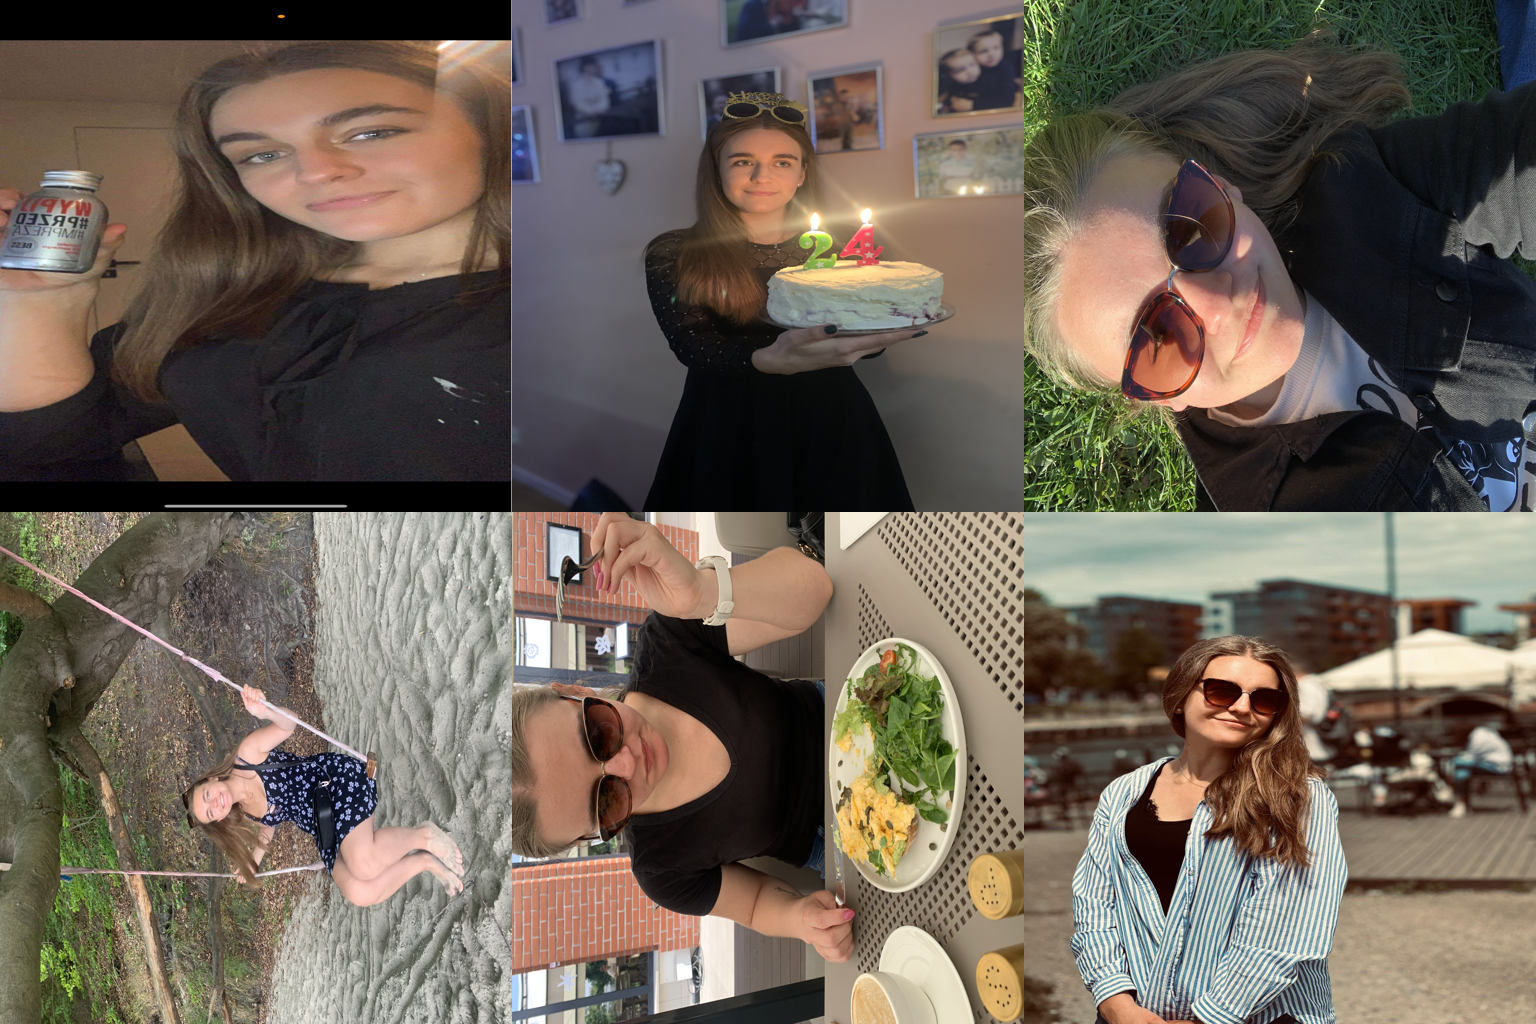

In [12]:
imgs = [Image.open(path) for path in glob.glob(CFG.data_dir + "/*")]
image_grid(imgs[0:6], 2, 3)

# Przygotowanie

In [13]:
# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained(CFG.blip_cap)
blip_model = BlipForConditionalGeneration.from_pretrained(CFG.blip_cap ,torch_dtype = CFG.dtype).to(CFG.device)

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Ten fragment kodu ładuje dwa kluczowe komponenty do generowania opisów obrazów:

1. `blip_processor` - wczytuje procesor z modelu BLIP, który odpowiada za przygotowanie obrazów do analizy. Używa ścieżki zdefiniowanej wcześniej w `CFG.blip_cap`.

2. `blip_model` - ładuje właściwy model BLIP do generowania opisów. Podczas ładowania:
   - używa tej samej ścieżki co procesor (`CFG.blip_cap`)
   - ustawia format danych na 16-bitowe liczby zmiennoprzecinkowe (`CFG.dtype`)
   - przenosi model na kartę graficzną (`to(CFG.device)`)

BLIP to model AI, który potrafi generować tekstowe opisy obrazów. W tym przypadku będzie używany jako część większego systemu do trenowania modelu generacji obrazów.

In [14]:

# create a list of (Pil.Image, path) pairs
local_dir = "/content/images/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{CFG.data_dir}*.jpeg")]

valid_extensions = ['.jpg', '.JPG', '.jpeg']
imgs_and_paths = [(path, Image.open(path)) for path in glob.glob(f"{local_dir}*.*")
                  if Path(path).is_file() and Path(path).suffix.lower() in valid_extensions]

Ten kod tworzy listę par zawierających ścieżki do plików oraz obrazy. Działa następująco:

1. `local_dir` definiuje ścieżkę do katalogu z obrazami w Google Colab

2. `glob.glob(f"{local_dir}*.jpg")` wyszukuje wszystkie pliki z rozszerzeniem .jpg w podanym katalogu

3. Lista składana `[(path, Image.open(path)) for path...]` tworzy dla każdego znalezionego pliku parę:
   - `path` - ścieżka do pliku
   - `Image.open(path)` - obraz wczytany jako obiekt PIL.Image

Utworzona lista `imgs_and_paths` będzie zawierać wszystkie znalezione obrazy wraz z ich lokalizacją w systemie plików, co umożliwi późniejsze przetwarzanie i odwoływanie się do konkretnych plików.

In [ ]:
caption_prefix = "a photo of kpb, "

with open(f'metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

Ten fragment kodu tworzy plik metadata.jsonl z opisami obrazów. Działanie kodu:

1. `caption_prefix` ustawia stały początek każdego opisu jako "a photo of kpb, "

2. Kod otwiera plik 'metadata.jsonl' w trybie zapisu i dla każdego obrazu z listy `imgs_and_paths`:

   - generuje opis obrazu używając funkcji `caption_images()` i dodaje prefiks
   - tworzy słownik `entry` zawierający:
     - nazwę pliku (wyciągniętą ze ścieżki)
     - pełny opis (prompt) składający się z prefiksu i wygenerowanego opisu
   - zapisuje każdy wpis jako osobną linię w formacie JSON

Format JSONL oznacza, że każda linia pliku zawiera jeden kompletny obiekt JSON. Taki plik będzie później używany do trenowania modelu, dostarczając mu pary obraz-opis.

In [ ]:
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

Ten kod zwalnia pamięć po zakończeniu generowania opisów obrazów:

1. `del blip_processor, blip_model` usuwa z pamięci procesor i model BLIP, które nie są już potrzebne

2. `gc.collect()` wywołuje ręcznie odśmiecacz pamięci Pythona, który usuwa nieużywane obiekty

3. `torch.cuda.empty_cache()` zwalnia pamięć GPU zajmowaną przez PyTorch

Te operacje są ważne przy pracy z dużymi modelami AI, ponieważ pozwalają zwolnić zasoby pamięci RAM i GPU przed załadowaniem kolejnych modeli lub wykonaniem następnych operacji.

# Model - trenujemy

In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"

Ta linia kodu wymusza kodowanie UTF-8 jako domyślne kodowanie znaków w systemie.

`locale.getpreferredencoding` to funkcja, która zwraca preferowane kodowanie znaków dla danego systemu. Nadpisanie jej funkcją lambda, która zawsze zwraca "UTF-8", zapewnia spójne kodowanie tekstu niezależnie od ustawień systemowych.

Jest to szczególnie przydatne przy pracy z tekstem w różnych językach lub gdy chcemy uniknąć problemów z kodowaniem znaków w różnych środowiskach.

In [ ]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


Ta komenda konfiguruje bibliotekę Accelerate do domyślnych ustawień.

Accelerate to narzędzie, które upraszcza uruchamianie modeli uczenia maszynowego na różnych urządzeniach (CPU, jedna karta GPU, wiele kart GPU). Komenda `config default` tworzy podstawowy plik konfiguracyjny z domyślnymi ustawieniami dla dostępnego sprzętu.

Po wykonaniu tej komendy Accelerate będzie gotowy do użycia z optymalnymi ustawieniami dla danego systemu.

In [ ]:
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0"  \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="/content/images/" \
  --output_dir="kpb_lora" \
  --caption_column="prompt"\
  --instance_prompt="a photo of kpb" \
  --resolution=1024 \
  --train_batch_size=1 \
  --num_train_epochs=3 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

2025-02-18 10:31:59.776249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739874719.802505    2791 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739874719.809389    2791 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
02/18/2025 10:32:05 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

tokenizer%2Ftokenizer_config.json: 100% 737/737 [00:00<00:00, 4.41MB/s]
tokenizer%2Fvocab.json: 100% 1.06M/1.06M [00:00<00:00, 1.65MB/s]
tokenizer%2Fmerges.txt: 100% 525k/525k [00:00<00:00, 835kB/s]
tokenizer%2Fspecial_tokens_map.json: 100% 472/472 [00:0

Ten kod uruchamia skrypt trenowania modelu Dreambooth z użyciem LoRA dla Stable Diffusion XL. Parametry treningu:

Podstawowe ustawienia:
- używa bazowego modelu SDXL 1.0 i zoptymalizowanego VAE
- obrazy treningowe pobiera z katalogu "/content/images/"
- zapisuje wyniki w katalogu "kpb_lora"
- prompt dla trenowanych obrazów: "a photo of kpb"

Parametry treningu:
- rozdzielczość obrazów: 1024x1024
- rozmiar batcha: 1 obraz
- liczba epok: 1
- akumulacja gradientu co 3 kroki
- włączone gradient checkpointing dla oszczędzania pamięci
- współczynnik uczenia: 0.0001
- gamma SNR: 5.0
- stała wartość współczynnika uczenia (scheduler "constant")
- brak kroków rozgrzewki (warmup)

Optymalizacje:
- używa precyzji FP16
- optymalizator Adam w wersji 8-bitowej
- maksymalnie 500 kroków treningu
- zapisywanie checkpointów co 717 kroków
- ziarno losowości: 0

Komenda uruchamiana jest przez `accelerate launch`, co pozwala na zoptymalizowane wykorzystanie dostępnego sprzętu.

In [ ]:
!ls ./kpb_lora/

ls: cannot access './kpb_lora/': No such file or directory


# HF

In [ ]:
output_dir = "kpb_lora"
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

Ten kod przygotowuje informacje do publikacji modelu na HuggingFace Hub:

1. `output_dir = "kpb_lora"` ustawia nazwę katalogu z wytrenowanym modelem

2. `whoami(token=Path("/root/.cache/huggingface/"))["name"]` pobiera nazwę użytkownika z tokenu HuggingFace zapisanego w podanej ścieżce

3. `repo_id = f"{username}/{output_dir}"` tworzy identyfikator repozytorium łącząc:
   - nazwę użytkownika
   - nazwę katalogu z modelem

Utworzony `repo_id` będzie używany jako pełna ścieżka do repozytorium na HuggingFace Hub, gdzie zostanie opublikowany model.

In [ ]:
repo_id = create_repo(repo_id, exist_ok=True).repo_id

Ta linia tworzy lub aktualizuje repozytorium na HuggingFace Hub:

`create_repo()` przyjmuje dwa parametry:
- `repo_id` - identyfikator repozytorium utworzony wcześniej
- `exist_ok=True` - pozwala na użycie istniejącego repozytorium zamiast zgłaszania błędu

Funkcja zwraca obiekt repozytorium, z którego pobierany jest `repo_id`. Jest to zabezpieczenie na wypadek, gdyby powstał nieco inny identyfikator niż początkowo zakładano.

In [ ]:
save_model_card(
    repo_id = repo_id,
    use_dora = False,
    images=[],
    base_model = CFG.model,
    train_text_encoder=False,
    instance_prompt= "a photo of kpb",
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path = CFG.vae,
)

README.md:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Ten kod generuje kartę modelu (model card) dla wytrenowanego modelu na HuggingFace Hub. Parametry:

- `repo_id` - identyfikator repozytorium gdzie zostanie zapisana karta
- `images=[]` - pusta lista obrazów do karty modelu
- `base_model` - ścieżka do bazowego modelu SDXL
- `train_text_encoder=False` - informacja, że enkoder tekstu nie był trenowany
- `instance_prompt` - prompt użyty podczas treningu
- `validation_prompt=None` - brak promptu walidacyjnego
- `repo_folder` - katalog z wytrenowanym modelem
- `vae_path` - ścieżka do użytego modelu VAE

Karta modelu to dokumentacja zawierająca kluczowe informacje o modelu, co pomaga innym użytkownikom zrozumieć jego możliwości i sposób użycia.

In [ ]:
upload_folder(
    repo_id=repo_id,
    folder_path= "kpb_lora",
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1737640311.ff1d460309ae.2633.1:   0%|          | 0.00/3.31k [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

events.out.tfevents.1737640311.ff1d460309ae.2633.0:   0%|          | 0.00/125k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/konradb/kpb_lora2/commit/d9d0d4a963e0d6a0ba5e7499c5ed0897b90287ef', commit_message='End of training', commit_description='', oid='d9d0d4a963e0d6a0ba5e7499c5ed0897b90287ef', pr_url=None, repo_url=RepoUrl('https://huggingface.co/konradb/kpb_lora2', endpoint='https://huggingface.co', repo_type='model', repo_id='konradb/kpb_lora2'), pr_revision=None, pr_num=None)

Ten kod służy do wysyłania folderu z plikami do repozytorium. Funkcja `upload_folder()` przyjmuje kilka parametrów:

`repo_id` określa identyfikator repozytorium, do którego pliki mają zostać wysłane. Jest to unikalny identyfikator wskazujący konkretne repozytorium.

`folder_path` wskazuje ścieżkę do lokalnego folderu, który ma zostać wysłany. W tym przypadku jest to folder określony przez zmienną `output_dir`.

`commit_message` definiuje wiadomość, która zostanie dołączona do commita. Tutaj ustawiono ją na "End of training", co sugeruje, że wysyłane są pliki wygenerowane po zakończeniu treningu modelu.

`ignore_patterns` to lista wzorców plików, które mają zostać pominięte podczas wysyłania. W tym przypadku pomijane są wszystkie pliki zaczynające się od "step_" oraz "epoch_" - pliki pośrednie generowane w trakcie treningu.

In [ ]:
link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

Ten kod tworzy link do wytrenowanego modelu na platformie Hugging Face i wyświetla go użytkownikowi w sformatowany sposób.

W pierwszej linii zmienna `link_to_model` jest tworzona poprzez połączenie bazowego adresu "https://huggingface.co/" ze zmienną `repo_id`, która zawiera nazwę repozytorium modelu.

Druga linia używa funkcji `display()` do pokazania tekstu w interfejsie. Tekst jest formatowany jako Markdown - nagłówek trzeciego poziomu "Your model has finished training" oraz link do modelu w nowej linii. Funkcja `format()` wstawia wcześniej utworzony link w miejsce znacznika `{}`.

Kod służy jako komunikat końcowy informujący użytkownika o zakończeniu treningu modelu i udostępniający bezpośredni link do niego na platformie Hugging Face.

# Model - generujemy

In [ ]:

vae = AutoencoderKL.from_pretrained(CFG.vae, torch_dtype = CFG.dtype)
pipe = DiffusionPipeline.from_pretrained(
    CFG.model,
    vae=vae,
    torch_dtype=torch.float16,
    variant = CFG.variant,
    use_safetensors=True
)


pipe.load_lora_weights(repo_id)
_ = pipe.to(CFG.device)

Ten kod konfiguruje model generacji obrazów typu Stable Diffusion. Przeanalizujmy go krok po kroku:

Najpierw tworzony jest obiekt VAE (Variational Autoencoder) poprzez załadowanie pre-trenowanego modelu ze ścieżki określonej w `CFG.vae`. VAE jest odpowiedzialny za kodowanie i dekodowanie obrazów.

Następnie inicjalizowany jest główny model Diffusion Pipeline. Przyjmuje on kilka parametrów:
- Ścieżkę do modelu bazowego (`CFG.model`)
- Wcześniej utworzony VAE
- Typ danych ustawiony na float16 dla oszczędności pamięci
- Wariant modelu określony w `CFG.variant`
- Flaga `use_safetensors=True` włącza bezpieczniejszy format przechowywania tensors

W kolejnym kroku do modelu ładowane są wagi LoRA (Low-Rank Adaptation) z określonego repozytorium. LoRA to technika dostrajania modelu, która pozwala na modyfikację jego zachowania przy użyciu stosunkowo małej liczby parametrów.

Na końcu cały model jest przenoszony na określone urządzenie zdefiniowane w `CFG.device`. Znak `_` jest używany do przechwycenia zwracanej wartości, która nas nie interesuje.

In [ ]:
prompt = "A photo of kpb giving a press conference"

image = pipe(prompt=prompt, num_inference_steps=30).images[0]
image

Ten kod służy do generowania obrazu przy użyciu modelu AI. Składa się z dwóch głównych części:

W pierwszej linii definiowana jest zmienna `prompt` zawierająca tekstowy opis obrazu, który ma zostać wygenerowany - w tym przypadku jest to "A photo of kpb giving a press conference" (zdjęcie kpb podczas konferencji prasowej).

W drugiej linii następuje właściwe generowanie obrazu:
- `pipe()` to funkcja modelu generatywnego
- `prompt` przekazuje wcześniej zdefiniowany opis tekstowy
- `num_inference_steps=25` określa liczbę kroków procesu generowania (im więcej kroków, tym potencjalnie lepszy obraz, ale dłuższy czas generowania)
- `.images[0]` pobiera pierwszy (i jedyny) wygenerowany obraz z listy wyników
- wynik zapisywany jest do zmiennej `image`

Ostatnia linia `image` wyświetla wygenerowany obraz.